# Week 3: Forwards


## FINM 37400: Fixed Income

### Mark Hendricks

#### Winter 2023

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Forward Rates

A given date's term structure encodes information about rates **in the future**.

## Example

Suppose...
- an investor will be receiving (risk-free) 100 million in 1 year ($T_1=1$)
- the investor wants to invest the (risk-free) for one additional year ($T_2=2$)
- at that point, the investor will take the funds and invest them in a risky project

Consider the following...
- Today, ($t$) the investor wants to fix the interest rate earned on the 100 million between the time it is received ($T_1$) and deployed ($T_2$)
- Today, what rate can we offer to this investor, effective between $T_1$ and $T_2$?

**This forward interest rate is encoded in the time-$t$ term structure!**

## Looking at the Data

Consider the quoted treasuries on the date shown below.

In [2]:
QUOTE_DATE = '2021-12-31'

bonds = get_bond(QUOTE_DATE,maturity=[.5,1],coupon=0)
display(bonds)

,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,,
207816,2021-12-30,2022-06-30,NaN,0.0,0.001877,0.495890,0.495551,99.906986
207818,2021-12-30,2022-12-29,NaN,0.0,0.003809,0.994521,0.993840,99.621875


### The answer

The rate we can guarantee today, effective starting 6 months from now, through 12 months from now is given below.

* Sell a forward contract today ($t$) to receive 100m in 6 months for repayment in 12 months with the TBD forward interest rate.
* Simultaneously at $t$, sell short the 6mo t-bill and use the proceeds to invest in the 12mo Tbill.
* At 6mo, use the proceeds from the forward counterparty to repay the 6mo treasury.
* At 12mo, use the proceeds from the 12mo t-bill to pay off the forward loan.

We have a perfectly hedged position at all times.

Thus, the forward rate must equal the gain from the 12mo tbill.
* Note that we actually bought $$\frac{P_t^{(\text{6mo})}}{P_t^{(\text{12mo})}}$$ units of the 12mo tbill.

In [3]:
FREQ_COMPOUNDING = 2
CAPITAL = 100
FACE_VALUE = 100

Nshort = -CAPITAL / FACE_VALUE
p_1 = bonds['price'].iloc[0]
p_2 = bonds['price'].iloc[1]

hedge_ratio =  - Nshort * p_1 / p_2

cash_forward = hedge_ratio * FACE_VALUE
forward_rate = FREQ_COMPOUNDING * (cash_forward / CAPITAL - 1)

display(f'The annualized semi-annual rate offered: {forward_rate:.4%}')

'The annualized semi-annual rate offered: 0.5724%'

### The guaranteed forward rate

Given this **forward** dollar exposure, the investor is guaranteed the following **semiannual** compounded rate, **annualized**.

In [4]:
label_rate = 'interest rate between $T_1$ and $T_2$'

ex_summary = pd.DataFrame({'investment at $T_1$':[100],'distribution at $T_2$':[cash_forward],\
              label_rate: [forward_rate]},\
             index=['forward investment']).T

ex_summary.style.format('{:.4f}')\
    .format(formatter='{:.4%}',subset=pd.IndexSlice[label_rate,:])\
    .applymap(lambda x: "background-color: lightcoral", subset=pd.IndexSlice[label_rate,:])

,forward investment
investment at $T_1$,100.0000
distribution at $T_2$,100.2862
interest rate between $T_1$ and $T_2$,0.5724%


## Interim Risk

Above, we did not deal with the price of the forward replication but for the special dates $T_1$ and $T_2$.

The forward replication's value will move over in the interim.

It is replicated by treasuries, so it is subject to interest-rate risk.

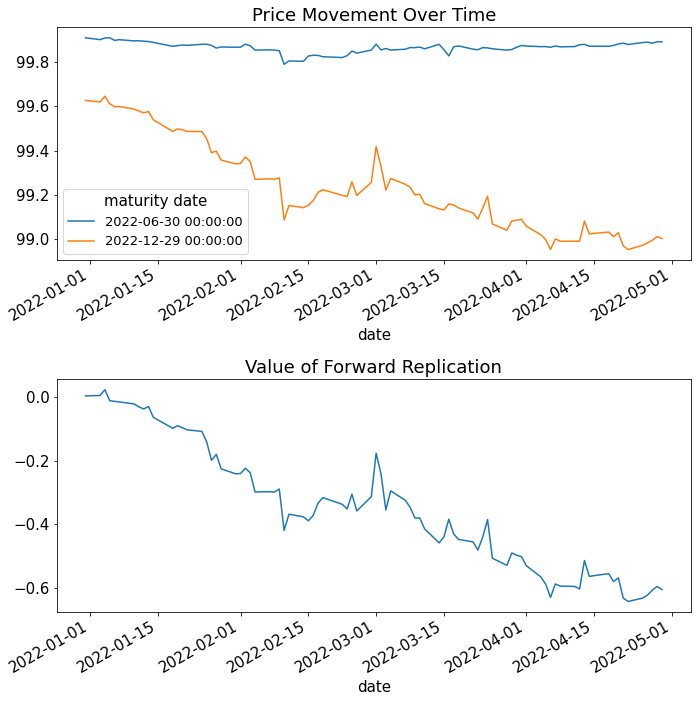

In [5]:
filepath_tsdata = '../data/treasury_ts_issue_(207816, 207818).xlsx'
tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()

price = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK') + tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
price = price.loc[QUOTE_DATE:]
price.columns = bonds['maturity date']

val_forward = hedge_ratio * price.iloc[:,1] - price.iloc[:,0]

fig, ax = plt.subplots(2)
price.plot(ax=ax[0],title='Price Movement Over Time',xlabel='date',figsize=(10,10))
val_forward.plot(ax=ax[1],title='Value of Forward Replication',xlabel='date')
plt.tight_layout()
plt.show()

# Calculating Foward Rates

Extract it from the **spot curve**, or equivalently, the **discount curve**.
- Spot curve: $r(t,T)$,
- Discount curve: $Z(t,T)$

Let $T_1$ and $T_2$ be two future dates, with
$$ t \le T_1 \le  T_2$$

### Forward Discount Factors
Define the **forward discount factor** as

$\begin{align}
F(t,T_1,T_2) = \frac{Z(t,T_2)}{Z(t,T_1)}
\end{align}$

This is the time-$t$ implied discount factor effective over $T_1$ to $T_2$.

Given this definition, answer the following:
- For $T_2=T_1$, what is $F(t,T_1,T_2) = ?$
- Is $F(t,T_1,T_2)$ increasing or decreasing in $T_2$?
- What is $F(t,t,T)$?

As we defined both a spot rate, $r(t,T)$ and equivalent discount factor, $Z(t,T)$, it is convenient to express this forward information not just as a forward discount factor, but also its equivalent rate.

### Forward Discount Rates

The **forward discount rate** is given as

$\begin{align}
f(t,T_1,T_2) \equiv & \quad -\frac{\ln\left\{F(t,T_1,T_2)\right\}}{T_2-T_1}\\[6pt]
F(t,T_1,T_2) = & \quad e^{-f(t,T_1,T_2)(T_2-T_1)}
\end{align}$

Note how the relationship between $f$ and $F$ is analagous to the relationship between $r$ and $Z$.

## The Forward Curve

The **forward curve** gives holds constant $t$ and the interval $\Delta = T_2-T_1$ while varying $T_1$. 

$\begin{align}
f(t,T_1,T_1+\Delta)
\end{align}$

when holding the interval between $T_1$ and $T_2$ constant at $\Delta$, it is common to denote $T$ instead of $T_1$:

$\begin{align}
f(t,T,T+\Delta)
\end{align}$

### Extracting the forward curve from the spot curve
Using the formulas above, calculate,

$\begin{align}
\{r(t,T_1),\, r(t,T_2)\}\Longrightarrow \{Z(t,T_1),\, Z(t,T_2)\}\Longrightarrow F(t,T_1,T_2)\Longrightarrow f(t,T_1,T_2)
\end{align}$

Apply this to data, using the following estimation:

In [6]:
quote_dates = ['2007-01-02','2021-12-31','2022-09-30']
MODEL = nelson_siegel
DELTA = .5
MULT = 1

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    curve_set = dict()
    for qdate in quote_dates:
        curve_set[qdate] = extract_spot_curves(qdate, model=MODEL, delta_maturity=DELTA, calc_forward=True, delta_forward_multiple=MULT)

curves_set = pd.concat(curve_set,axis=1,names=['quote date','curves'])

model_labels = {'Bootstrap':bootstrap, 'Nelson-Siegel':nelson_siegel, 'NS-Extended':nelson_siegel_extended}
model_label = list(model_labels.keys())[list(model_labels.values()).index(MODEL)]

display(f'Quoted Data: {QUOTE_DATE}.')
display(f'Model for spot curve: {model_label}.')

'Quoted Data: 2021-12-31.'

'Model for spot curve: Nelson-Siegel.'

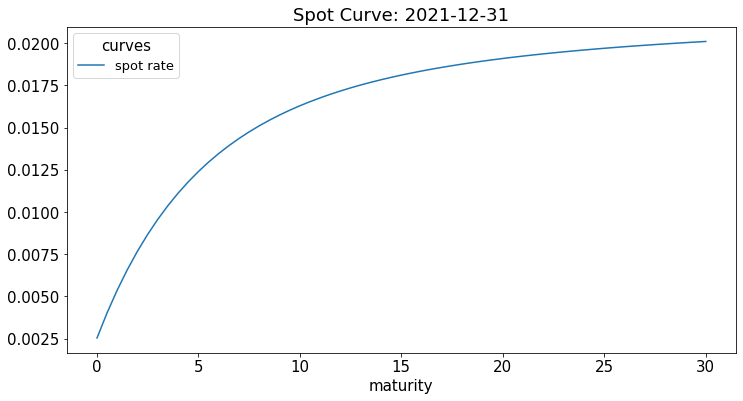

In [7]:
curves = curves_set[QUOTE_DATE]
curves[['spot rate']].plot(title=f'Spot Curve: {QUOTE_DATE}')
plt.show()

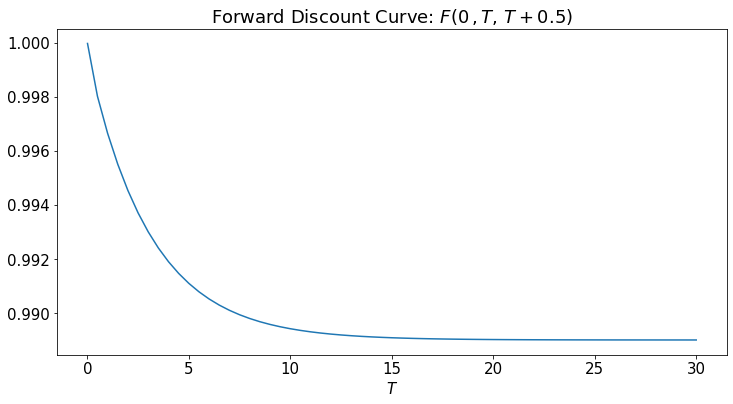

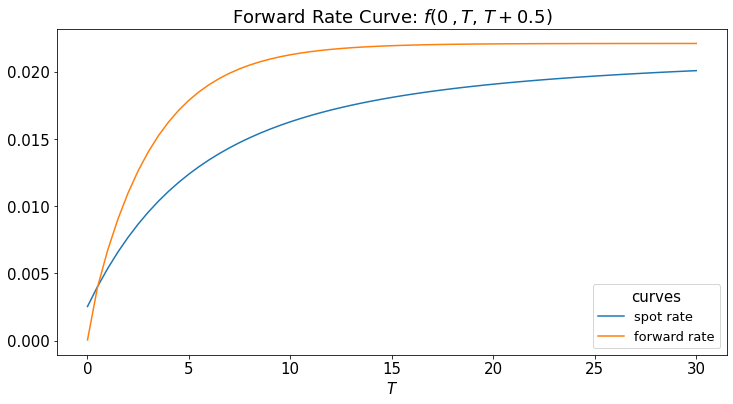

In [8]:
label_title = f'Forward Discount Curve: $F(0\, ,T,\,T+{DELTA})$'
curves['forward discount'].plot(title=label_title, xlabel='$T$')
plt.show()

label_title = f'Forward Rate Curve: $f(0\, ,T,\,T+{DELTA})$'
curves[['spot rate','forward rate']].plot(title=label_title, xlabel='$T$')
plt.show()

### Relationship between the spot curve and the forward curve

The **forward curve** is closely related to the spot curve. In one sense, the forward curve is the derivative of the spot curve, with respect to $T$, again holding $T_2-T_1$ constant at $\Delta$.

$\begin{align}
f(0,T,T+\Delta) = r(0,T) + (T+\Delta)\,\underbrace{\frac{r(0,T+\Delta)-r(0,T)}{\Delta}}_{\text{slope of spot curve}}
\end{align}$

Note then that the forward rate...
* is the spot rate plus a term that is positive (negative) if the spot curve has an increasing (decreasing) slope.
* the forward curve is above the spot curve if, and only if, the spot curve is sloping upward.

### Compounding

As for any rate, we must specify the compounding.
* $f(t,T_1,T_2)$ above is continuously compounded, as is the spot rate, $r(t,T)$.
* We could specify a compounding frequency to get

$\begin{align}
f_n(t,T_1,T_2) \equiv & \quad n\left(\frac{1}{F(t,T_1,T_2)^{\frac{1}{n(T_2-T_1)}}}-1\right)\\[6pt]
F(t,T_1,T_2) = & \quad \frac{1}{\left(1+\frac{f_n(t,T_1,T_2)}{n}\right)^{n(T_2-T_1)}}
\end{align}$

Note that
* $F$ is defined irrespective of compounding.
* Compounding only impacts the rate, $f$.
* This is analagous to $Z$ being defined absolutely and $r$ being defined with respect to a compounding frequency.

Typically, we will focus on continuously compounded forward rates, $f(t,T_1,T_2)$ as we focused on continuously compounded spot rates, $r(t,T)$.

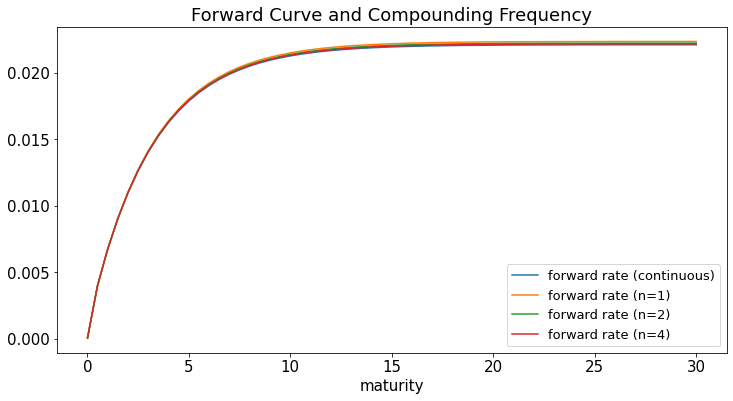

In [9]:
forwards_compounded = curves[['forward rate']].copy()
forwards_compounded.columns = ['forward rate (continuous)']

compounds = [1,2,4]
for n in compounds:
    forwards_compounded[f'forward rate (n={n})'] = compound_rate(forwards_compounded['forward rate (continuous)'],None,n)
    
forwards_compounded.plot(title='Forward Curve and Compounding Frequency')
plt.show()

### Extracting the spot curve from the forward curve

It is possible to "bootstrap" the spot curve from forward rates. Consider the following formulas,

#### Bootstrap the Spot Discount
$\begin{align}
Z(0,T_n) = Z(0,T_{n-1})e^{-f(0,T_{n-1},T_n)\Delta}
\end{align}$

This procedure can be initialized by noting that $f(t,t,T) = r(t,T)$. Thus,

$\begin{align}
Z(0,T_1) = e^{-r(0,T_1)\Delta}
\end{align}$

Stringing these together for various $n$ we have,

$\begin{align}
Z(0,T_n) = \exp\left\{-\left[r(0,T_1)\Delta + f(0,T_1,T_2)\Delta + \ldots + f(0,T_{n-1},T_n)\Delta\right]\right\}
\end{align}$

#### Converting to the Spot Rate
$\begin{align}
r(0,T_n) = \frac{1}{T_n}\sum_{i=1}^nf(0,T_{i-1},T_i)\Delta
\end{align}$

where 
* $T_0=0$, 
* $f(0,0,T_1) = r(0,T_1)$.

### Example

Below, we use the forward curve on the stated date to extract the day's spot curve.

'Quote Date: 2007-01-02'

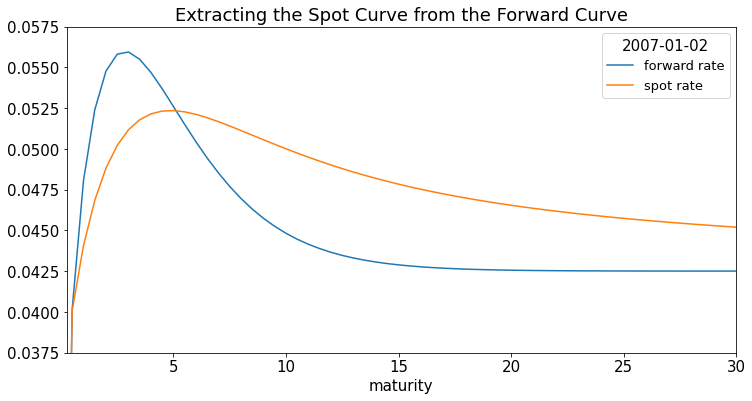

In [10]:
QUOTE_DATE_ALT = '2007-01-02'

display(f'Quote Date: {QUOTE_DATE_ALT}')
curves_imputed = curves_set[QUOTE_DATE_ALT][['forward rate']]
curves_imputed.columns.name = QUOTE_DATE_ALT

mat_grid = curves_imputed.index.to_series()
delta_grid = mat_grid.diff()
# assuming first delta is same as second delta
delta_grid.iloc[0] = delta_grid.iloc[1]

curves_imputed['spot rate'] = (curves_imputed['forward rate'] * delta_grid).cumsum(skipna=True) / mat_grid
curves_imputed['spot rate'].iloc[0] = curves_imputed['forward rate'].iloc[0]

curves_imputed.plot(title='Extracting the Spot Curve from the Forward Curve',xlim=(.25,30),ylim=(.0375,.0575))
plt.show()

## Importance of a Smooth Spot Curve

Given that the forward curve is a derivative of the spot curve...
* a smooth spot curve implies a smooth forward curve
* small measurement error in the spot curve may lead to large measurement error in the forward curve

Consider extracting the spot curve using a bootstrap instead of a model such as Nelson-Siegel.

The spot rate and spot discount look reasonable, but their implied forward curves are not fit for use.

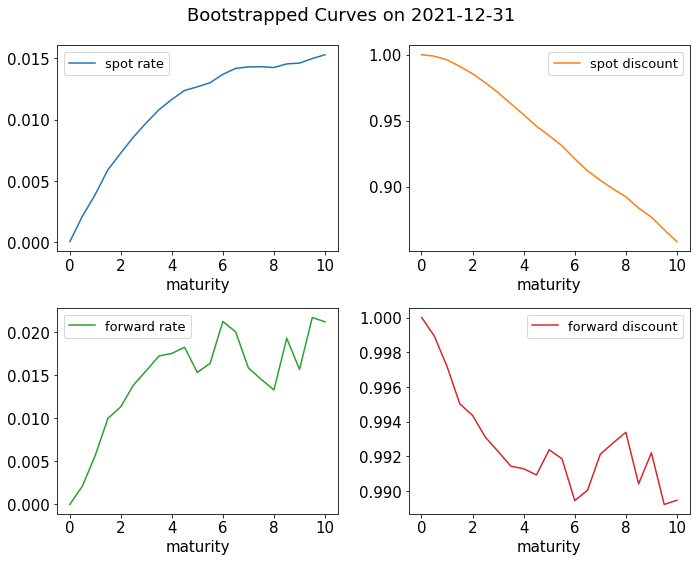

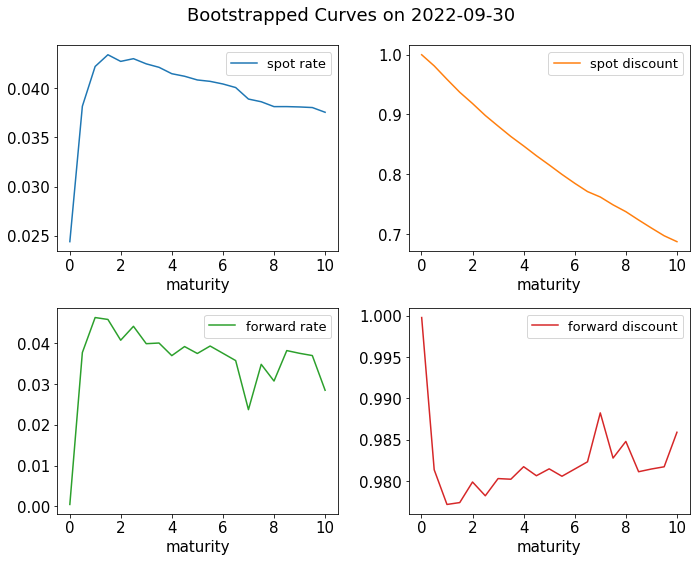

In [11]:
for DATE in quote_dates[1:]:
    curveOLS = extract_spot_curves(DATE, model=bootstrap, delta_maturity=DELTA, T=10, calc_forward=True,delta_forward_multiple=MULT, filter_maturity_dates=True)
    fig, ax = plt.subplots(2,2,tight_layout=True,figsize=(10,8))
    curveOLS.plot(subplots=True,ax=ax,title=f'Bootstrapped Curves on {DATE}')
    plt.show()

## Forward Rate Agreements

### Definition
A Forward Rate Agreement (FRA) is similar to the financing provided in the example above. 

There are a few differences. In an FRA, 
- the party entering the FRA does not deposit the capital. (In the example above, the investor deposits the 100mm at $T_1$.
- rather, the party entering the FRA pays the spot rate, $r(T_1,T_2)$, on the notional.

The net receipt for the investor is, using a compounding frequency, $n$,

$\begin{align}
& \quad N \Delta\left[f_n(0,T_1,T_2)-r_n(T_1,T_2)\right]\\[6pt]
\Delta \equiv & \quad T_2-T_1\\[6pt]
N \equiv & \quad \text{Notional Investment}
\end{align}$

## Forward Contracts

### Definition
A forward contract is an agreement to buy a bond with maturity $T$...
- at a specific time in the future, $T_0$
- at a specific price, $P_{\text{Fwd}}(t,T_0,T)$

#### Note 
Here we use $T_0$ to denote the date of the forward, and $T$ to denote the date of the maturity, 
- Not $T_1$ and $T_2$ as above. 
- This is for notational convenience below.


#### Initalization
The forward price is set such that there is no price to initiate the forward contract. 
* That is, the value to the contract is 0 at initialization

#### Final payoff
The final payoff from the long forward contract on the bond is, (at $T_0$)

$\begin{align}
V_{\text{Fwd}}(T_0,T) = P(T_0,T) - P_{\text{Fwd}}(0,T_0,T)
\end{align}$

### Price vs Value
Like with FRAs, it is important to carefully distinguish the **forward price** from the **value** of an FRA or **value** of a forward contract.

The initial **price** of the forward contract is set such that the **value** is zero.

Thereafter, 
* the **value** of the contract will move with interest rates.

* the **forward price** is a contract parameter and will be effective at $T_0$

At an interim time $0<t<T_0$, we have the following formula for the value of a forward contract on a treasury bond:

$\begin{align}
V_{\text{Fwd}}(t,T_0,T) = Z(t,T_0)\left[P_{\text{Fwd}}(t,T_0,T) - P_{\text{Fwd}}(0,T_0,T)\right]
\end{align}$

This equation simply says that the interim value is 
* what it would cost to enter an offsetting short forward
* netted against the price already promised at $t=0$
* discounted back to $t$, as these payments will happen at $T_0$.

Note that this interim value will vary with interest rates, as they impact $P(t,T)$.

## Forward Contracts on Treasury Bonds

### Pricing

Pricing forward contracts on treasuries is easy:
* just use the discount $F(t,T_0,T)$ instead of $Z(t,T)$!

#### Zero coupon bond

- Consider a zero-coupon bond maturing at $T$, with face value of 100.
- Consider a forward contract, initialized at $t$ for purchase at $T_0$.

$\begin{align}
P_{\text{Fwd}}(t,T_0,T) = 100F(t,T_0,T)
\end{align}$

#### Coupon bond
Consider now that there are coupons at $T_i$, with final principal repaid at $T_n=T$.

$\begin{align}
P_{\text{Fwd}}(t,T_0,T) = 100\frac{c}{2}\sum_{i=1}^nF(t,T_0,T_i) + 100F(t,T_0,T)
\end{align}$

### Example
The forward contract can achieve the same thing as the FRA above.

Again, consider the investor receiving 100 million at $T_0=$ 6 months and wishing to lock in an interest rate from $T_0$ to $T=$ 12 months.

Try doing it with a forward contract on the 1-year T-bill. Recall the instruments available,

In [12]:
display(bonds)

,issue date,maturity date,outstanding,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,,
207816,2021-12-30,2022-06-30,NaN,0.0,0.001877,0.495890,0.495551,99.906986
207818,2021-12-30,2022-12-29,NaN,0.0,0.003809,0.994521,0.993840,99.621875


The plan is...
* go long the forward contract on the Dec 2022 T-bill
* at $T_0=$ 6 months, add or subtract the forward contract cashflow to the received 100 million
* invest the net proceeds into Dec 2022 T-bill.

In [13]:
p_forward_contract = curves['forward discount'].loc[.5]
n_forward_contracts = CAPITAL / p_forward_contract

payment = p_forward_contract * n_forward_contracts
payoff = n_forward_contracts 

annualized_semiannual_forward_rate = (payoff / CAPITAL - 1)*2

frate_cont = curves['forward rate'].loc[.5]
frate_semi = compound_rate(curves['forward rate'],None,2).loc[.5]

tab_ex_prices = pd.DataFrame([['contracted forward price',p_forward_contract],\
            ['number of forward contracts',n_forward_contracts],\
            ['payment at $T_0$',payment],\
            ['payoff at $T$',payoff]])

tab_ex_rates = pd.DataFrame([\
                    ['annualized return from $T_0$ to $T$', annualized_semiannual_forward_rate],\
                    ['forward rate (continuous)',frate_cont],\
                    ['forward rate (semiannual)',frate_semi]])

tab_ex_prices.columns = ['','value']
tab_ex_prices.set_index('',inplace=True)

tab_ex_rates.columns = ['','value']
tab_ex_rates.set_index('',inplace=True)

index_rates = tab_ex_rates.index
index_highlight = index_rates[[0,2]]

display(pd.concat([tab_ex_prices,tab_ex_rates],axis=0).style.format("{:.4f}")\
    .format(formatter='{:.4%}',subset=pd.IndexSlice[index_rates,:])\
    .applymap(lambda x: "background-color: lightcoral", subset=pd.IndexSlice[index_highlight,:]))

,value
,
contracted forward price,0.9980
number of forward contracts,100.1983
payment at $T_0$,100.0000
payoff at $T$,100.1983
annualized return from $T_0$ to $T$,0.3965%
forward rate (continuous),0.3962%
forward rate (semiannual),0.3965%


# Appendix: Mathematical Details

## FRAs

### Value

The equation above gives the **net cashflow** of the FRA at maturity.

The **value** of the FRA is the cashflow above, discounted by the appropriate spot discount factor, $Z(t,T)$.

The result is the **following equation**:

$\begin{align}
V_{\text{FRA}}(t;0,T_1,T_2) = N\Delta\left[f_n(0,T_1,T_2)-f_n(t,T_1,T_2)\right]Z(t,T_2)
\end{align}$

Note that the price is a function of 4 dates:
- $t=0$: initialization date of the forward
- $T_1$: the date of the spot rate fix
- $T_2$: the date of settlement
- $t$: the date of the pricing


#### Boundaries
Note that 
- For $t=0$, the value is 0. That is, an FRA is set up such that no payment is required at initialization.
- One could view this as the determining feature of the forward price.
- For $t=T_2$, we get the value equals the net cashflow at maturity given above,

$\begin{align}
V_{\text{FRA}}(0;0,T_1,T_2) =& \quad  N\Delta\left[f_n(0,T_1,T_2)-f_n(0,T_1,T_2)\right]Z(0,T_2) = 0\\ 
V_{\text{FRA}}(T_2;0,T_1,T_2) =& \quad N \Delta\left[f_n(0,T_1,T_2) - r_n(T_1,T_2)\right]
\end{align}$

In [14]:
t0 = '2021-12-31'
t = '2022-03-31'
T1 = '2022-06-30'
T2 = '2022-12-31'

curve_interim = extract_spot_curves(t, model=MODEL, delta_maturity=.25, calc_forward=True, delta_forward_multiple=2)

fra = DELTA * MULT * (curve_set[QUOTE_DATE].loc[.5,'forward rate'] - curve_interim.loc[.25,'forward rate']) * curve_interim.loc[.75,'spot discount']
fra_hypothetical = DELTA * MULT * (curve_set[QUOTE_DATE].loc[.5,'forward rate'] - curve_interim.loc[.5,'spot rate'])

fra_tab = pd.DataFrame({'$f(0,T_1,T_2)$': curve_set[QUOTE_DATE].loc[.5,'forward rate'], '$f(t,T_1,T_2)$': curve_interim.loc[.25,'forward rate'], '$r(T_1,T_2)$':np.nan, '$Z(t,T_2)$': curve_interim.loc[.75,'spot discount'], '$P(t;0,T_1,T_2)$': fra},index=[t]).T
fra_tab_hypo = pd.DataFrame({'$f(0,T_1,T_2)$': curve_set[QUOTE_DATE].loc[.5,'forward rate'], '$f(t,T_1,T_2)$':np.nan, '$r(T_1,T_2)$': curve_interim.loc[.5,'spot rate'], '$Z(t,T_2)$': 1, '$V(t;0,T_1,T_2)$': fra_hypothetical},index=[f'Hypothetical: {T1}']).T

index_special = fra_tab.index[-2:]
index_highlight = fra_tab.index[-1]

pd.concat([fra_tab,fra_tab_hypo],axis=1)

,2022-03-31,Hypothetical: 2022-06-30
"$f(0,T_1,T_2)$",0.003962,0.003962
"$f(t,T_1,T_2)$",0.001149,NaN
"$r(T_1,T_2)$",NaN,0.009972
"$Z(t,T_2)$",0.988878,1.000000
"$P(t;0,T_1,T_2)$",0.001390,NaN
"$V(t;0,T_1,T_2)$",NaN,-0.003005


## Forward Treasuries

### Pricing the forward contract on Treasuries

From above, we have the value of a forward contract at $t$

$\begin{align}
V_{\text{Fwd}}(t,T_0,T) = Z(t,T_0)\left[P_{\text{Fwd}}(t,T_0,T) - P_{\text{Fwd}}(0,T_0,T)\right]
\end{align}$

And we have the forward price for a Treasury:

$\begin{align}
P_{\text{Fwd}}(t,T_0,T) = 100\frac{c}{2}\sum_{i=1}^nF(t,T_0,T_i) + 100F(t,T_0,T)
\end{align}$

#### Note again that the value of a forward contract and forward price are different!

The forward price is whatever value initializes the value to be zero. 

Thus, after the contract is initialized, $P_{\text{Fwd}}(0,T_0,T)$ is a parameter. 

Let us denote, $K = P_{\text{Fwd}}(0,T_0,T)$.

Then we have the value of the forward contract on treasuries as,

$\begin{align}
V_{\text{Fwd}}(t,T_0,T) = Z(t,T_0)\left[100\frac{c}{2}\sum_{i=1}^nF(t,T_0,T_i) + 100F(t,T_0,T) - K\right]
\end{align}$

***

# Appendix: Forward Rates via No-Arbitrage

### No-Arbitrage

The answer above is implied by the two treasury securities along with an assumption of **no arbitrage**.

Specifically, we can use the time-$t$ offerings to replicate saving between $T_1$ and $T_2$.

The chart below shows the
- quantity
- price
- dollar position

at each point in time
- $t$
- $T_1$ gross
- $T_1$ net
- $T_2$ gross
- $T_2$ net

Note that the financer has a net-$0 position at every poinot in time.
* See the `total` column.
* This depends on the price of the `forward`

In [15]:
n_cash = [0,100,0,0,0]
n_forwards = [-1,-1,-1,-1,0]
n_1 = [-1, -1, 0, 0,0]
n_2 = hedge_ratio * np.array([1,1,1,1,0])

holdings = pd.DataFrame({'forward':n_forwards, 'cash':n_cash, 'tbill 6mo':n_1, 'tbill 12mo':n_2},index=['t','pre-$T_1$','post-$T_1$','pre-$T_2$','post-$T_2$'])

prices = pd.DataFrame(index=holdings.index,columns=holdings.columns,dtype=float)
prices['cash'] = [1,1,1,1,1]
prices['forward'] = [0,np.nan,np.nan,hedge_ratio*FACE_VALUE,hedge_ratio*FACE_VALUE]
prices['tbill 6mo'] = [p_1,100,100,np.nan,np.nan]
prices['tbill 12mo'] = [p_2,np.nan,np.nan,100,100]

bank_position = (holdings * prices).fillna(0)
bank_position['total'] = bank_position.sum(axis=1)

arb_chart = pd.concat([holdings,prices,bank_position],keys=['quantity','price','$ position'],axis=1)

display(arb_chart.style.applymap(lambda x: "background-color: lightgray", subset='quantity')\
    .applymap(lambda x: "background-color: lightyellow", subset='price')\
    .applymap(lambda x: "background-color: lightblue", subset='$ position')\
    .format('{:.2f}'))

#### Price of the forward

How did we determine the price of the `forward`?
- $t$: the forward is arranged (by convention) to have an initial price of 0
- $T_1$: the price does not matter for this replication.
- $T_2$: no-arbitrage implies the displayed price must hold, given that it is consistent with the replicating portfolio

In [16]:
display(arb_chart['price'].style.applymap(lambda x: "background-color: lightyellow")\
        .applymap(lambda x: "background-color: yellow", subset='forward')\
        .format('{:.2f}'))

,forward,cash,tbill 6mo,tbill 12mo
t,0.00,1.00,99.91,99.62
pre-$T_1$,nan,1.00,100.00,nan
post-$T_1$,nan,1.00,100.00,nan
pre-$T_2$,100.29,1.00,nan,100.00
post-$T_2$,100.29,1.00,nan,100.00


#### Dollar position of the replication

With these **forward** prices, we get the replicating portfolio has a net-0 dollar total.

In [17]:
display(bank_position.style.applymap(lambda x: "background-color: lightblue")\
        .applymap(lambda x: "background-color: cornflowerblue",subset='total')\
        .format('{:.2f}'.format))

,forward,cash,tbill 6mo,tbill 12mo,total
t,-0.00,0.00,-99.91,99.91,0.00
pre-$T_1$,0.00,100.00,-100.00,0.00,0.00
post-$T_1$,0.00,0.00,0.00,0.00,0.00
pre-$T_2$,-100.29,0.00,0.00,100.29,0.00
post-$T_2$,0.00,0.00,0.00,0.00,0.00


# Appendix: Curves on Different Dates

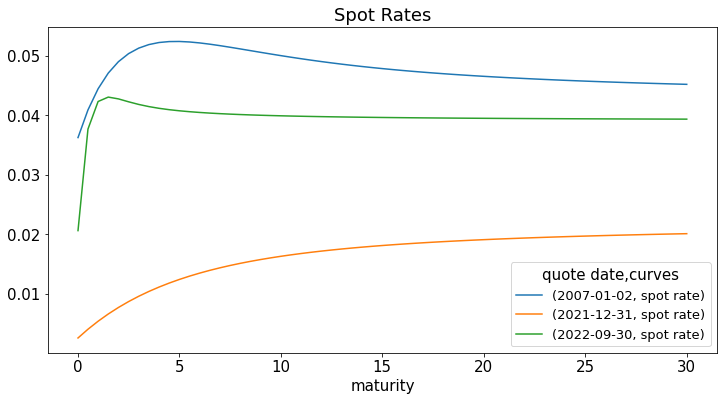

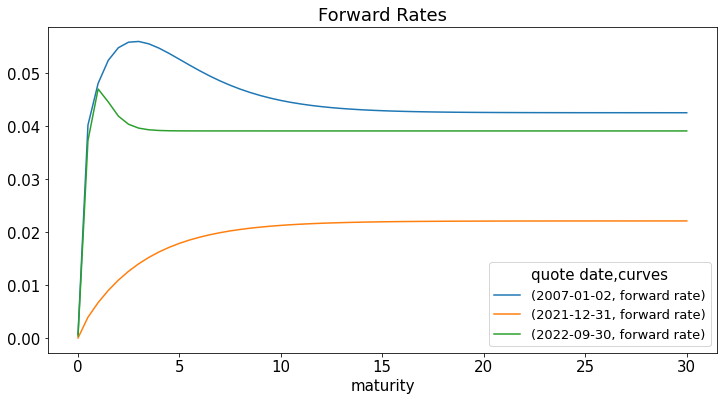

In [18]:
idx = pd.IndexSlice
curves_set.loc[:,idx[:,['spot rate']]].plot(title='Spot Rates')
plt.show()
curves_set.loc[:,idx[:,['forward rate']]].plot(title='Forward Rates')
plt.show()